In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns

indir = '/home/hsher/scratch/circ_nextera_iter5/output/'
circ_quant_output = [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
indir = '/home/hsher/scratch/circ_nextera_iter13/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
indir = '/home/hsher/scratch/circ_nextera_iter2/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf') 
                      and f.startswith('HEK_rar11')]
indir = '/home/hsher/scratch/circ_nextera/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf') 
                      and f.startswith('circseq-bm-rar11')]

In [2]:
circ_quant_output

['/home/hsher/scratch/circ_nextera_iter5/output/IGF2BP2_sort_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter5/output/U2AF2_sort_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter13/output/APOBEC1only.gtf',
 '/home/hsher/scratch/circ_nextera_iter13/output/YTHDF2_STAMP.gtf',
 '/home/hsher/scratch/circ_nextera_iter13/output/RBM15_STAMP.gtf',
 '/home/hsher/scratch/circ_nextera_iter2/output/HEK_rar11.gtf',
 '/home/hsher/scratch/circ_nextera/output/circseq-bm-rar11-nxt.gtf']

In [3]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [4]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
for fname in circ_quant_output:
    name = os.path.basename(fname).replace('.gtf', '')
    names.append(name)
    
    circ_df, stat = read_ciri_gtf(fname)
    
    circ_type_count.append(circ_df['circ_type'].value_counts())
    
    junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))

In [5]:
stats_df = pd.concat(stats, axis = 1).T

In [6]:
stats_df.columns

Index(['##Sample', '##Total_Reads', '##Mapped_Reads', '##Circular_Reads',
       '##version'],
      dtype='object', name=0)

In [7]:
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

In [8]:
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']

In [9]:
stats_df.sort_values('frac_circular')
stats_df.set_index('##Sample', inplace = True)

In [10]:
stats_df

,##Total_Reads,##Mapped_Reads,##Circular_Reads,##version,frac_circular,frac_mapped
##Sample,,,,,,
IGF2BP2_sort_rar11,124795606,97051686,919680,1.1.2,0.009476,0.777685
U2AF2_sort_rar11,109180826,91254738,1158206,1.1.2,0.012692,0.835813
APOBEC1only,80236596,57932274,1127116,1.1.2,0.019456,0.722018
YTHDF2_STAMP,103670066,84671150,1413240,1.1.2,0.016691,0.816737
RBM15_STAMP,95184010,81332700,1512904,1.1.2,0.018601,0.854479
HEK_rar11,288352678,238307158,5730676,1.1.2,0.024047,0.826443
circseq-bm-rar11-nxt,337446430,294910186,4307176,1.1.2,0.014605,0.873947


In [11]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names

In [12]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names

In [13]:
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names

In [14]:
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names

Text(0.5, 0, '# circRNA detected')

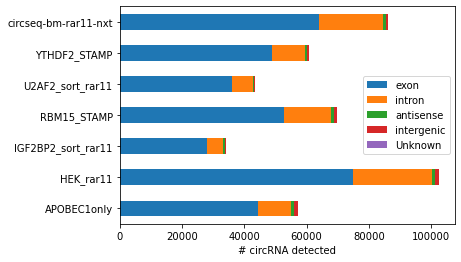

In [15]:
import matplotlib.pyplot as plt
counts.T.sort_index().plot.barh(stacked = True)
plt.xlabel('# circRNA detected')

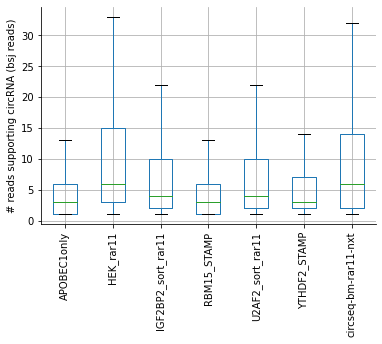

In [16]:
bsj.reindex(sorted(bsj.columns), axis=1).boxplot(showfliers=False, rot = 90)
plt.ylabel('# reads supporting circRNA (bsj reads)')
sns.despine()

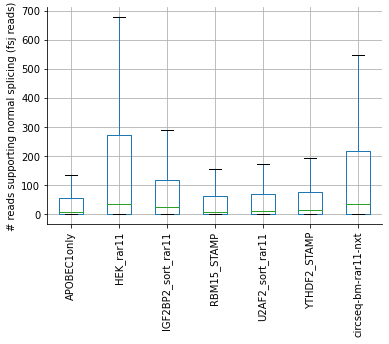

In [17]:
fsj.reindex(sorted(fsj.columns), axis=1).boxplot(showfliers=False, rot = 90)
plt.ylabel('# reads supporting normal splicing (fsj reads)')
sns.despine()

Text(0, 0.5, '(BSJ+1)/(FSJ+1)')

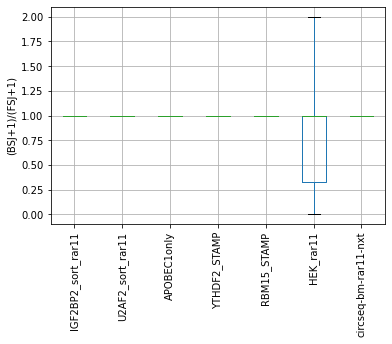

In [18]:
((bsj.fillna(0)+1)/(fsj.fillna(0)+1)).boxplot(showfliers=False, rot = 90)
plt.ylabel('(BSJ+1)/(FSJ+1)')

In [26]:
(bsj.notnull()).groupby(bsj.columns.tolist()).count()

Empty DataFrame
Columns: []
Index: [(False, False, False, False, False, False, True), (False, False, False, False, False, True, False), (False, False, False, False, False, True, True), (False, False, False, False, True, False, False), (False, False, False, False, True, False, True), (False, False, False, False, True, True, False), (False, False, False, False, True, True, True), (False, False, False, True, False, False, False), (False, False, False, True, False, False, True), (False, False, False, True, False, True, False), (False, False, False, True, False, True, True), (False, False, False, True, True, False, False), (False, False, False, True, True, False, True), (False, False, False, True, True, True, False), (False, False, False, True, True, True, True), (False, False, True, False, False, False, False), (False, False, True, False, False, False, True), (False, False, True, False, False, True, False), (False, False, True, False, False, True, True), (False, False, True, False, True, False, False), (False, False, True, False, True, False, True), (False, False, True, False, True, True, False), (False, False, True, False, True, True, True), (False, False, True, True, False, False, False), (False, False, True, True, False, False, True), (False, False, True, True, False, True, False), (False, False, True, True, False, True, True), (False, False, True, True, True, False, False), (False, False, True, True, True, False, True), (False, False, True, True, True, True, False), (False, False, True, True, True, True, True), (False, True, False, False, False, False, False), (False, True, False, False, False, False, True), (False, True, False, False, False, True, False), (False, True, False, False, False, True, True), (False, True, False, False, True, False, False), (False, True, False, False, True, False, True), (False, True, False, False, True, True, False), (False, True, False, False, True, True, True), (False, True, False, True, False, False, False), (False, True, False, True, False, False, True), (False, True, False, True, False, True, False), (False, True, False, True, False, True, True), (False, True, False, True, True, False, False), (False, True, False, True, True, False, True), (False, True, False, True, True, True, False), (False, True, False, True, True, True, True), (False, True, True, False, False, False, False), (False, True, True, False, False, False, True), (False, True, True, False, False, True, False), (False, True, True, False, False, True, True), (False, True, True, False, True, False, False), (False, True, True, False, True, False, True), (False, True, True, False, True, True, False), (False, True, True, False, True, True, True), (False, True, True, True, False, False, False), (False, True, True, True, False, False, True), (False, True, True, True, False, True, False), (False, True, True, True, False, True, True), (False, True, True, True, True, False, False), (False, True, True, True, True, False, True), (False, True, True, True, True, True, False), (False, True, True, True, True, True, True), (True, False, False, False, False, False, False), (True, False, False, False, False, False, True), (True, False, False, False, False, True, False), (True, False, False, False, False, True, True), (True, False, False, False, True, False, False), (True, False, False, False, True, False, True), (True, False, False, False, True, True, False), (True, False, False, False, True, True, True), (True, False, False, True, False, False, False), (True, False, False, True, False, False, True), (True, False, False, True, False, True, False), (True, False, False, True, False, True, True), (True, False, False, True, True, False, False), (True, False, False, True, True, False, True), (True, False, False, True, True, True, False), (True, False, False, True, True, True, True), (True, False, True, False, False, False, False), (True, False, True, False, False, False, True), (True, False, True, False, False, True, False), (True, False, True, False, Fal

Text(0, 0.5, '# detected')

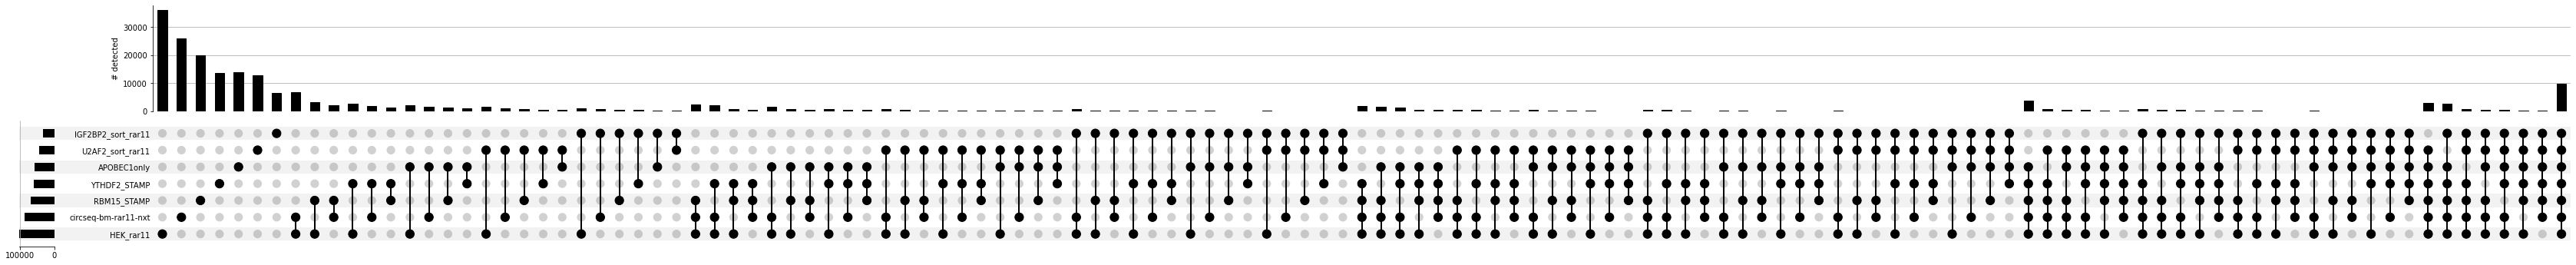

In [28]:
from upsetplot import plot
detected = bsj.notnull()
detected['is']=1
plot(detected.groupby(bsj.columns.tolist())['is'].sum(),
    )
plt.ylabel('# detected')
